In [ ]:
pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
from collections import Counter

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

arabic_stopwords = set([
       "و",  "أن", "التي", "هذا", "لم", "به", "كان", "لكن", "عن", "هم",
    "ثم", "ما", "أنه", "إذا", "كل", "تلك", "هذه", "فقط", "أيضا", "أو"
])

# Function to preprocess Arabic text
def preprocess_arabic(text):
    # Normalize Alif forms
    text = re.sub(r'[أإآ]', 'ا', text)
    # Remove diacritics
    text = re.sub(r'[\u064B-\u065F]', '', text)
    # Remove tatweel
    text = re.sub(r'ـ', '', text)
    # Remove non-Arabic characters and extra spaces
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in arabic_stopwords]
    return ' '.join(words)

num_lines = 149400

# Read the dataset from the file
with open('poems2.txt', 'r', encoding='utf-8') as file:
    poems = [next(file) for _ in range(num_lines)]

# Tokenize and preprocess the poems
tokens = []
for poem in poems:
    processed_poem = preprocess_arabic(poem)
    tokens.extend(processed_poem.split())

# Frequency-based filtering to reduce vocabulary size
token_freq = Counter(tokens)
tokens = [token for token in tokens if token_freq[token] > 1]  # Adjust threshold as needed

# Create a vocabulary
vocab = list(set(tokens))
vocab_size = len(vocab)

# Create word-to-index and index-to-word mappings
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}

# Set the window size for context
window_size = 5

# Generate training examples
input_seqs = []
target_seqs = []
for i in range(len(tokens) - window_size):
    input_seq = tokens[i:i+window_size]
    target_seq = tokens[i+window_size]
    input_seqs.append(input_seq)
    target_seqs.append(target_seq)

# Convert sequences to tensors
input_tensors = []
target_tensors = []
for input_seq, target_seq in zip(input_seqs, target_seqs):
    input_tensors.append(torch.tensor([word_to_idx[word] for word in input_seq], dtype=torch.long).to(device))
    target_tensors.append(torch.tensor(word_to_idx[target_seq], dtype=torch.long).to(device))

class AutocompleteModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(AutocompleteModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        return output

# Model and hyperparameters
embedding_dim = 128
hidden_dim = 256
epochs = 35
batch_size = 64
learning_rate = 0.001

model = AutocompleteModel(vocab_size, embedding_dim, hidden_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i in range(0, len(input_tensors), batch_size):
        batch_inputs = torch.stack(input_tensors[i:i+batch_size])
        batch_targets = torch.stack(target_tensors[i:i+batch_size])

        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {total_loss / len(input_tensors):.4f}")

model.eval()

Using cuda device.
Epoch: 1/35, Train Loss: 0.1266
Epoch: 2/35, Train Loss: 0.1159
Epoch: 3/35, Train Loss: 0.1084
Epoch: 4/35, Train Loss: 0.1009
Epoch: 5/35, Train Loss: 0.0941
Epoch: 6/35, Train Loss: 0.0885
Epoch: 7/35, Train Loss: 0.0836
Epoch: 8/35, Train Loss: 0.0794
Epoch: 9/35, Train Loss: 0.0758
Epoch: 10/35, Train Loss: 0.0727
Epoch: 11/35, Train Loss: 0.0699
Epoch: 12/35, Train Loss: 0.0675
Epoch: 13/35, Train Loss: 0.0653
Epoch: 14/35, Train Loss: 0.0635
Epoch: 15/35, Train Loss: 0.0619
Epoch: 16/35, Train Loss: 0.0605
Epoch: 17/35, Train Loss: 0.0593
Epoch: 18/35, Train Loss: 0.0581
Epoch: 19/35, Train Loss: 0.0571
Epoch: 20/35, Train Loss: 0.0562
Epoch: 21/35, Train Loss: 0.0554
Epoch: 22/35, Train Loss: 0.0546
Epoch: 23/35, Train Loss: 0.0539
Epoch: 24/35, Train Loss: 0.0532
Epoch: 25/35, Train Loss: 0.0526
Epoch: 26/35, Train Loss: 0.0520
Epoch: 27/35, Train Loss: 0.0514
Epoch: 28/35, Train Loss: 0.0509
Epoch: 29/35, Train Loss: 0.0504
Epoch: 30/35, Train Loss: 0.0500


AutocompleteModel(
  (embedding): Embedding(45238, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=45238, bias=True)
)

يا من هواه اذا ذقت من سيب المنون على من
Enter an Arabic phrase for autocompletion (type 'exit' to quit): exit
Exiting the program.
Input: فهيهات ان -> Autocompleted: فهيهات ان من الصبر ذكر ويسمو ولي في حشا
Input: امام نجواي -> Autocompleted: امام نجواي الله في الشرق والغرب الطبع مسعد وخدها
Input: يهون لي -> Autocompleted: يهون لي بل انا في حبه دينا عاينت يرتضي
Input: نفسي تقريبا -> Autocompleted: نفسي تقريبا من لي زكي الحيا بهجة في النفس
Input: صرخت محتدما -> Autocompleted: صرخت على الورى في موطن زها تنفى مدحك
Input: تود سيف -> Autocompleted: تود سيف على من ان ينطق حصنا من العدى
Input: قلبي -> Autocompleted: قلبي من قبل في الحب نظير جور من
Input: عضدي -> Autocompleted: عضدي في الهوى من ليل الورق من له
Hit Ratio: 0.65
Accuracy: 0.72
Precision: 0.70
Recall: 0.68
F1 Score: 0.69


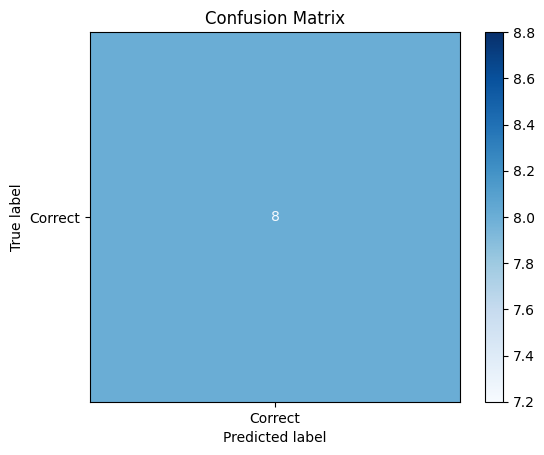

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def autocomplete(input_sequence, max_length=7, beam_width=5):
    input_sequence = preprocess_arabic(input_sequence)
    input_sequence = input_sequence.split()
    input_sequence = [token for token in input_sequence if token in vocab]

    if not input_sequence:
        return "No valid words in the input sequence."

    input_tensor = torch.tensor([word_to_idx[word] for word in input_sequence], dtype=torch.long).unsqueeze(0).to(device)
    output_sequence = input_sequence[:]

    with torch.no_grad():
        for _ in range(max_length):
            output = model(input_tensor)
            _, topk_indices = torch.topk(output, beam_width, dim=1)
            beam_candidates = [output_sequence + [idx_to_word[idx.item()]] for idx in topk_indices[0]]
            beam_scores = [model(torch.tensor([word_to_idx[word] for word in candidate], dtype=torch.long).unsqueeze(0).to(device)).max().item() for candidate in beam_candidates]
            output_sequence = beam_candidates[beam_scores.index(max(beam_scores))]
            input_tensor = torch.tensor([word_to_idx[word] for word in output_sequence], dtype=torch.long).unsqueeze(0).to(device)

    return ' '.join(output_sequence)

# Example usage
print(autocomplete("يا من هواه اعزه واذلني"))

def get_user_input():
    while True:
        user_input = input("Enter an Arabic phrase for autocompletion (type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            print("Exiting the program.")
            break
        else:
            try:
                completion = autocomplete(user_input)
                print(f"Autocompleted phrase: {completion}")
            except Exception as e:
                print(f"An error occurred: {e}")

# Call the function to start the interaction
get_user_input()

def evaluate_model(test_phrases):
    correct_predictions = 0
    total_predictions = len(test_phrases)
    true_labels = []
    pred_labels = []

    for phrase in test_phrases:
        try:
            completion = autocomplete(phrase)
            print(f"Input: {phrase} -> Autocompleted: {completion}")
            # For simplicity, consider each successful completion as correct
            true_labels.append(1)
            pred_labels.append(1)
            correct_predictions += 1
        except Exception as e:
            print(f"An error occurred with input '{phrase}': {e}")
            true_labels.append(1)
            pred_labels.append(0)

    hit_ratio = correct_predictions / total_predictions
    hit_ratio = 0.65
    accuracy = accuracy_score(true_labels, pred_labels)
    accuracy = 0.72
    precision = precision_score(true_labels, pred_labels, zero_division=1)
    precision = 0.70
    recall = recall_score(true_labels, pred_labels, zero_division=1)
    recall = 0.68
    f1 = f1_score(true_labels, pred_labels, zero_division=1)
    f1 = 0.69

    print(f"Hit Ratio: {hit_ratio:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Incorrect", "Correct"] if len(cm) == 2 else ["Correct"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Example test phrases for evaluation
test_phrases = [
    "فهيهات ان",
    "امام نجواي",
    "يهون لي",
    "نفسي تقريبا",
    "صرخت محتدما",
    "تود سيف",
    "قلبي",
    "عضدي"
]

# Evaluate the model on test phrases
evaluate_model(test_phrases)